### Acknowledgement
Name: Zuha Aqib     
ERP ID: 26106    
Section: 10am Miss Solat     
Date: (written on) 08-Mar-25    

code has been taken from Miss Solat's code files and written by Zuha themselves. 

In [167]:
from datetime import datetime
print("Last time code executed:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Last time code executed: 2025-03-09 10:25:28


In [168]:
erp = 26106 
# will be referenced later on in the code when we use it for random_state
erp

26106

# Imports
here we import all the necessary libraries and modules

In [169]:
# to load the dataset
import warnings
warnings.filterwarnings('ignore')

# to handle the data and perform numerical operations on it
import pandas as pd
import numpy as np

# to do natural language processing
import nltk

# preprocessing: to clean the data
import re

# preprocessing: stop words removal
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# preprocessing: words tokenization
from nltk.tokenize import word_tokenize

# preprocessing: stemmming and lemmatization
from nltk.stem import WordNetLemmatizer

# model running
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# clustering: k means
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to plot the graph
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns

# Time Displayer
this code is a function that we will call at multiple instances of the code to see how long it took to run the code to see when it ran

In [170]:
# Function to get current date and time as a string
def get_current_datetime():
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Load the Dataset
Here we load the dataset from a csv file and then save it into a variable

In [171]:
df = pd.read_csv("dataset/news_Feb_14.csv")
df = df.iloc[:, 0]  # Select only the headline column
documents = df.tolist()  # Convert to list
documents

['ECC endorses purchase of $582mn capital shares in BRICS’s New Development Bank',
 'Netanyahu’s statement to establish Palestinian state in Saudi Arabia irresponsible, provocative: FO',
 'India, US agree to resolve trade and tariff rows after Trump-Modi talks',
 'Aurangzeb discusses Pakistan’s structural reforms with IFC chief',
 'HBL, S&P Global launch Pakistan’s first manufacturing PMI',
 'KSE-100 closes 479 points lower as late-session selling erases intra-day gains',
 'PPL executes agreements for Sui Gas Field operations',
 'Hubco Green, PSO collaborate to setup EV charging infrastructure across Pakistan',
 'Rupee records marginal improvement against US dollar',
 'At least 9 dead, 7 injured in Balochistan’s Harnai blast',
 'Gold adds to record rally, reaches Rs306,200 per tola in Pakistan',
 'IMF’s 2024 Article IV report, and debate on inflation—I',
 'Pakistan CPI 2024 – deep-rooted corruption persists',
 '‘Like a wormhole’: Musk promises ‘Dubai Loop’ tunnel network',
 'Reforming 

In [172]:
original_headlines = documents.copy()  # Keep original headlines before preprocessing

# Preprocessing
here we perform the preprocessing of data like:
- lowercase text
- stopword removal
- stemming or lemmatization
- n-grams

## Lowercase Conversion
here we convert our text to lowercase

In [173]:
documents = [document.lower() for document in documents]

print("Finished executing at:", get_current_datetime())
documents

Finished executing at: 2025-03-09 10:25:28


['ecc endorses purchase of $582mn capital shares in brics’s new development bank',
 'netanyahu’s statement to establish palestinian state in saudi arabia irresponsible, provocative: fo',
 'india, us agree to resolve trade and tariff rows after trump-modi talks',
 'aurangzeb discusses pakistan’s structural reforms with ifc chief',
 'hbl, s&p global launch pakistan’s first manufacturing pmi',
 'kse-100 closes 479 points lower as late-session selling erases intra-day gains',
 'ppl executes agreements for sui gas field operations',
 'hubco green, pso collaborate to setup ev charging infrastructure across pakistan',
 'rupee records marginal improvement against us dollar',
 'at least 9 dead, 7 injured in balochistan’s harnai blast',
 'gold adds to record rally, reaches rs306,200 per tola in pakistan',
 'imf’s 2024 article iv report, and debate on inflation—i',
 'pakistan cpi 2024 – deep-rooted corruption persists',
 '‘like a wormhole’: musk promises ‘dubai loop’ tunnel network',
 'reforming 

## Data Cleaning
here we clean the data

In [174]:
import re
import unicodedata

def clean_text(text):
    text = text.encode('ascii', 'ignore').decode()  # Remove non-ASCII characters
    text = unicodedata.normalize("NFKD", text)  # Normalize Unicode text
    
    # Separate numbers attached to words
    text = re.sub(r'(?<=\d)(?=[a-zA-Z])', ' ', text)  # number-word
    text = re.sub(r'(?<=[a-zA-Z])(?=\d)', ' ', text)  # word-number
    
    text = text.replace("-", " ") # replace hyphens with spaces to tokenize the numbers and words
    text = re.sub(r'[^\w\s,]', '', text)  # Remove everything except words, numbers, and commas
    text = re.sub(r'\s+', ' ', text).strip()   # remove extra spaces
    
    return text

In [175]:
documents = [clean_text(text) for text in documents]
documents

['ecc endorses purchase of 582 mn capital shares in bricss new development bank',
 'netanyahus statement to establish palestinian state in saudi arabia irresponsible, provocative fo',
 'india, us agree to resolve trade and tariff rows after trump modi talks',
 'aurangzeb discusses pakistans structural reforms with ifc chief',
 'hbl, sp global launch pakistans first manufacturing pmi',
 'kse 100 closes 479 points lower as late session selling erases intra day gains',
 'ppl executes agreements for sui gas field operations',
 'hubco green, pso collaborate to setup ev charging infrastructure across pakistan',
 'rupee records marginal improvement against us dollar',
 'at least 9 dead, 7 injured in balochistans harnai blast',
 'gold adds to record rally, reaches rs 306,200 per tola in pakistan',
 'imfs 2024 article iv report, and debate on inflationi',
 'pakistan cpi 2024 deep rooted corruption persists',
 'like a wormhole musk promises dubai loop tunnel network',
 'reforming pension funds i

## Stop Words Removal
here we remove stop words. we have three options of:
- either declaring all possible stop words and then iteratively checking each word in the document if its a stop word and then adding the non-stop words. 
```
sw = ["from","of","and", "on","for", "the","have","a","be","to","in","will","if","by","into","as"]
docs_list = []
for d in document: 
    d_nlp = nlp(d.lower())
    t_list = []
    for token in d_nlp:
        tok_lem = str(token.lemma_)
        if (tok_lem not in sw):
            t_list.append(tok_lem)
    str_ = ' '.join(t_list) 
    docs_list.append(str_)
docs_list
```
However this is not a good practice. 
- pulling stop words from ```ntlk``` library: 
```
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
documents_no_stopwords = [" ".join([word for word in doc.split() if word not in stop_words]) 
```
However after running this code it didnt not remove stop words thus i removed it
- intializing stop_words in ```CountVectorizer()``` however here we are not using it
- using the ```ENGLISH_STOP_WORDS``` in ```sklearn```
```
tokens = [word for word in tokens if word not in stopwords.words('english') and word not in ENGLISH_STOP_WORDS]  
```
Lets try it and see it how it goes.

In [176]:
# Tokenize each document
tokenized_docs = [word_tokenize(doc) for doc in documents] 

# Remove stop words
filtered_docs = [[word for word in doc if word not in stopwords.words('english') and word not in ENGLISH_STOP_WORDS] for doc in tokenized_docs]

# Convert back to sentences if needed
documents = [" ".join(doc) for doc in filtered_docs]

documents

['ecc endorses purchase 582 mn capital shares bricss new development bank',
 'netanyahus statement establish palestinian state saudi arabia irresponsible , provocative fo',
 'india , agree resolve trade tariff rows trump modi talks',
 'aurangzeb discusses pakistans structural reforms ifc chief',
 'hbl , sp global launch pakistans manufacturing pmi',
 'kse 100 closes 479 points lower late session selling erases intra day gains',
 'ppl executes agreements sui gas field operations',
 'hubco green , pso collaborate setup ev charging infrastructure pakistan',
 'rupee records marginal improvement dollar',
 '9 dead , 7 injured balochistans harnai blast',
 'gold adds record rally , reaches rs 306,200 tola pakistan',
 'imfs 2024 article iv report , debate inflationi',
 'pakistan cpi 2024 deep rooted corruption persists',
 'like wormhole musk promises dubai loop tunnel network',
 'reforming pension funds pakistan sustainable approach',
 'cjp afridi administers oath newly appointed sc judges',
 '

## Reduction
here we change words to a smaller common form instead of the 's. We do this using two ways:
- stemming
- lemmatization

here we perform lemmatization as in the previous assignment, lemmatization had worked much better

### Lemmatization
this also reduces words to their singular form and is said to be better as it only reduces to words in the dictionary. after our 48 trials in the previous assignment, lemmatization was much better.

In [177]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_doc(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

In [178]:
documents = [lemmatize_doc(doc) for doc in documents]
documents

['ecc endorses purchase 582 mn capital share bricss new development bank',
 'netanyahus statement establish palestinian state saudi arabia irresponsible , provocative fo',
 'india , agree resolve trade tariff row trump modi talk',
 'aurangzeb discusses pakistan structural reform ifc chief',
 'hbl , sp global launch pakistan manufacturing pmi',
 'kse 100 close 479 point lower late session selling erases intra day gain',
 'ppl executes agreement sui gas field operation',
 'hubco green , pso collaborate setup ev charging infrastructure pakistan',
 'rupee record marginal improvement dollar',
 '9 dead , 7 injured balochistans harnai blast',
 'gold add record rally , reach r 306,200 tola pakistan',
 'imf 2024 article iv report , debate inflationi',
 'pakistan cpi 2024 deep rooted corruption persists',
 'like wormhole musk promise dubai loop tunnel network',
 'reforming pension fund pakistan sustainable approach',
 'cjp afridi administers oath newly appointed sc judge',
 'solar panel import 8

## N-Grams
here we decide how we want the words to be tokenized, either they are
- unigram: singular
- bigram: pairs (doubular)

for this assignment, we will focus on unigrams.

In [179]:
# because we want unigrams, we DO NOT have to do anything and we will leave it the way it is

# Vectorization
here we convert the text to numerical format for the model to understand it. we have four ways to do it:
- word2Vec
- doc2vec

in this code we are exploring the first method

## Word2Vec
in word2vec we have two methods:
- cbow architecture (target is predicted by context)
- skipgram (target predicts context)

In [180]:
# for sg variable
sg = 0 # CBOW
# sg = 1 # Skip-Gram

sg

0

### Variables to set
here we set variables like vector_size, window_size, count of epochs etc. we define them here so that in the code we dont have to change them. We can easily change them here and the code will change accordingly.

one thing to note here is that before starting the assignment i will make a list of each variable and what i want to test. then i will iterate over each variable keeping rest fixed, and write a loop to iterate over that variable and then i will select that as best. then for the next i will use its list but that previous one will be in its best. this will help me run as many things as i want in one code run.

In [181]:
vector_size = [50, 100, 150, 200, 250, 300]
selected_vector_size = vector_size[0]

In [182]:
window = [3, 5, 7, 10, 12, 15, 20]
selected_window = window[0]

In [183]:
epochs = [50, 100, 150, 200, 250]
selected_epoch = epochs[0]

### Code declaration
here we declare our code using the following syntax

In [184]:
word2vec_model = Word2Vec(
    sentences=documents,                        # Tokenized text
    vector_size=selected_vector_size,           # Each word is represented by a x-dimensional vector
    window=selected_window,                     # Context window size
    min_count=1,                                # Ignores words that appear less than 'min_count' times
    workers=4,                                  # Number of CPU cores used
    sg=sg,                   
    epochs=selected_epoch                       # Number of training iterations
)

2025-03-09 10:25:30,268 : INFO : collecting all words and their counts
2025-03-09 10:25:30,269 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 10:25:30,272 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 10:25:30,276 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 10:25:30,277 : INFO : Creating a fresh vocabulary
2025-03-09 10:25:30,280 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T10:25:30.280361', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 10:25:30,281 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

In [185]:
def get_avg_word2vec(tokens, model, vector_size=300):
    vectors = [model.wv[word] for word in tokens if word in model.wv]  
    return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size) 

In [186]:
# Convert the list to a Pandas Series
documents_series = pd.Series(documents)

documents = documents_series.apply(lambda x: get_avg_word2vec(x, word2vec_model))

In [187]:
print(type(documents_series))

<class 'pandas.core.series.Series'>


In [188]:
documents = np.array(documents.tolist())

In [189]:
documents

array([[-5.81424423e-02, -2.32764613e-02,  3.53440568e-02, ...,
        -2.33068302e-01, -4.24831137e-02, -8.52837041e-02],
       [-8.57798010e-02, -4.49996665e-02,  7.17632994e-02, ...,
        -2.81095356e-01, -7.97649920e-02, -1.27635866e-01],
       [-8.28793123e-02, -2.23765280e-02,  5.50454520e-02, ...,
        -2.42640972e-01, -6.69461042e-02, -1.11982569e-01],
       ...,
       [-7.92619660e-02, -3.68370488e-02,  7.08201155e-02, ...,
        -2.87396044e-01, -1.00484446e-01, -1.31178752e-01],
       [-8.95384401e-02, -1.30659231e-04,  5.47338501e-02, ...,
        -2.44994327e-01, -7.32547045e-02, -1.42194897e-01],
       [-7.40838572e-02, -3.15725058e-02,  6.56178519e-02, ...,
        -2.11965293e-01,  5.96447056e-03, -3.92087065e-02]], dtype=float32)

# K Means Clustering
here we cluster the documents into similar categories using k means clustering algorithm. we will be testing the algorithm for three values of k: 5, 9 and 13

In [190]:
def display_k_means(k, data):
    print(f"Displaying {k} start time:", get_current_datetime())
    
    svd = TruncatedSVD(n_components=2, random_state=42)
    data = svd.fit_transform(data)
    
    kmeans = KMeans(n_clusters=k, random_state=erp)
    labels = kmeans.fit_predict(data)
    
    # Convert to DataFrame for visualization
    df_viz = pd.DataFrame({'X': data[:, 0], 'Y': data[:, 1], 'Cluster': labels})

    # Scatter plot of clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_viz, x='X', y='Y', hue='Cluster', palette='tab10', s=100, edgecolor='black')
    plt.title("K-Means Clustering Visualization (2D Projection)")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(title="Cluster")
    plt.show()
    
    print("Finished displaying at:", get_current_datetime(), "\n")

In [191]:
def run_k_means(k, data):
    print(f"Executing {k} start time:", get_current_datetime())
    
    kmeans = KMeans(n_clusters=k, random_state=erp)
    labels = kmeans.fit_predict(data)
    
    wss = kmeans.inertia_  # Within-Cluster Sum of Squares
    silhouette_avg = silhouette_score(data, labels)  # Silhouette Score
    
    print(f"K={k}: Silhouette Score and WSS={silhouette_avg:.4f}\t{wss:.4f}")
    
    values = [[silhouette_avg, wss]]
    # Create DataFrame and copy to clipboard
    df = pd.DataFrame(values)
    df.to_clipboard(index=False, header=False)
    print("copied to clipboard")
    
    # Create a DataFrame to store headlines with their assigned clusters
    df_clusters = pd.DataFrame({'Headline': original_headlines, 'Cluster': labels})

    # Display sample headlines per cluster
    for cluster in range(k):
        print(f"\nCluster {cluster}:")
        sample_headlines = df_clusters[df_clusters["Cluster"] == cluster].sample(n=min(5, len(df_clusters[df_clusters["Cluster"] == cluster])), random_state=erp)
        for idx, row in sample_headlines.iterrows():
            print(f"- {row['Headline']}")
    
    display_k_means(k, data)
    
    print("Finished executing at:", get_current_datetime(), "\n")

In [192]:
print(type(documents))

<class 'numpy.ndarray'>


Executing 5 start time: 2025-03-09 10:25:31
K=5: Silhouette Score and WSS=0.1699	6.0984
copied to clipboard

Cluster 0:
- Kuwait hosts high-level forum to discuss International Islamic Court of Justice
- PMDC, Kazakh govt vow to cooperate in medical education
- Power of AI brings Urdu books to life
- Markelle Fultz back in the NBA: Sacremento Kings sign former No. 1 pick
- KU VC Prof Dr Khalid Iraqi inaugurates second agricultural festival

Cluster 1:
- Page World Economy and Politics News ISB Page 5
- More than 500 million take ‘holy dip’ in India’s Maha Kumbh festival
- ‘Wacky Races’ character designer Jerry Eisenberg dies at 87
- 26 Year-Old TikToker Bailey Hutchins Tragically Passes Away After 2 Year Battle With Colon Cancer
- From The Past Pages Of Dawn: 1975: Fifty Years Ago: Secret deal denounced

Cluster 2:
- PM urges Turkish businessmen to invest in diverse fields
- Two soldiers hurt in Indian firing at LoC
- Commissioner travels in People’s Bus Service, takes information abou

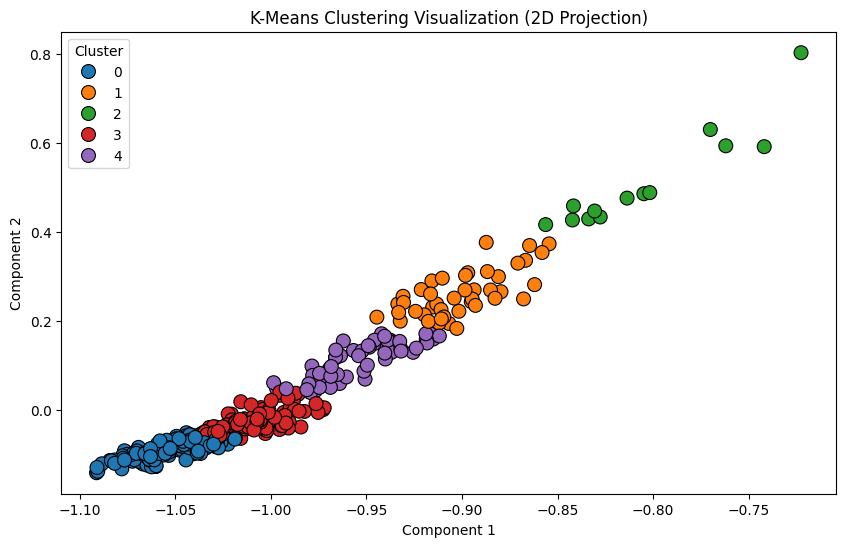

Finished displaying at: 2025-03-09 10:25:31 

Finished executing at: 2025-03-09 10:25:31 



In [193]:
run_k_means(5, documents)

Executing 9 start time: 2025-03-09 10:25:31
K=9: Silhouette Score and WSS=0.1189	5.0137
copied to clipboard

Cluster 0:
- Holding peaceful meetings democratic right of all parties, says Irfan Siddiqui
- CJP Afridi administers oath to newly-appointed SC judges
- Bid to desecrate Holy Quran foiled outside Turkish Consulate in London
- Local bodies members flexing muscles for another protest in Peshawar
- Google partners with Poland to expand AI adoption in key sectors

Cluster 1:
- Pakistan Air Force fighter Jets to kick off ICC Champions Trophy 2025 in Style
- India seen seeking global bids this year for 114 fighters
- Journalist killings reach record high in 2024
- SBP injects over Rs 1.9 trillion in market
- From The Past Pages Of Dawn: 1975: Fifty Years Ago: Secret deal denounced

Cluster 2:
- 7 Beauty Secrets Celebrities Swear By (And How You Can Steal Them!)
- Star Grammar School among 69 buildings sealed in Lahore
- 10 Movies to Watch at Home If You're Single on Valentine’s Day
- 

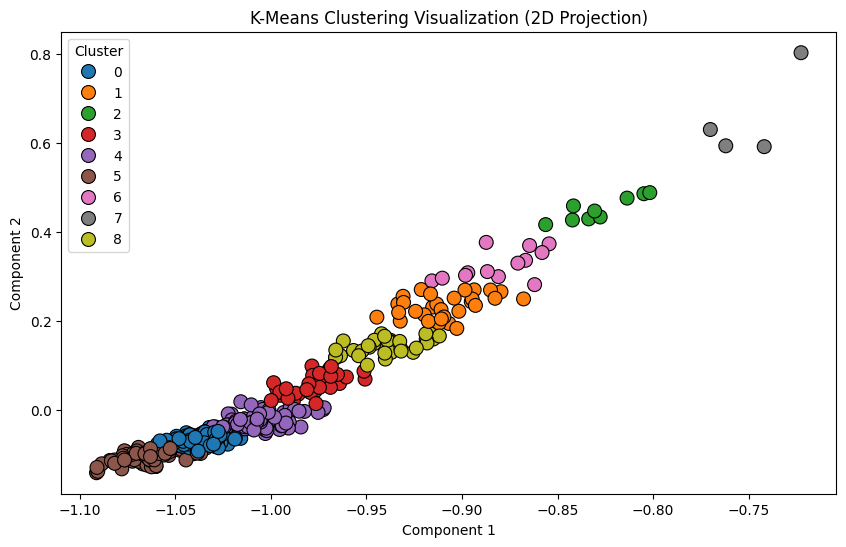

Finished displaying at: 2025-03-09 10:25:32 

Finished executing at: 2025-03-09 10:25:32 



In [194]:
run_k_means(9, documents)

Executing 13 start time: 2025-03-09 10:25:32
K=13: Silhouette Score and WSS=0.1081	4.4162
copied to clipboard

Cluster 0:
- South African rand firms after Trump’s tariff move; local budget next week
- IGP pays tributes to police martyrs of Faisal Chowk Mall Road tragedy
- PGF’s ‘train the trainers program’ boosts golf coaching in Pakistan
- CJP Yahya Afridi administers oath to six newly appointed SC judges
- Credits against tax WH: FBR issuing notices to salaried individuals: KTBA

Cluster 1:
- At least 10 dead, 6 injured as blast in Harnai targets pickup truck carrying mine workers
- 394th annual Urs of Hazrat Ishan starts
- Rajat Patidar named RCB captain for IPL 2025 as Virat Kohli gets snubbed
- PFC makes significant impact at 11th IDF
- Deadly blast in Harnai kills 11 coal miners, injures four

Cluster 2:
- Gold set for seventh weekly gain as trade war risks lift demand
- ‘We risk losing hold on reality’: Scarlett Johansson slams AI video of stars protesting against Kanye
- Govt h

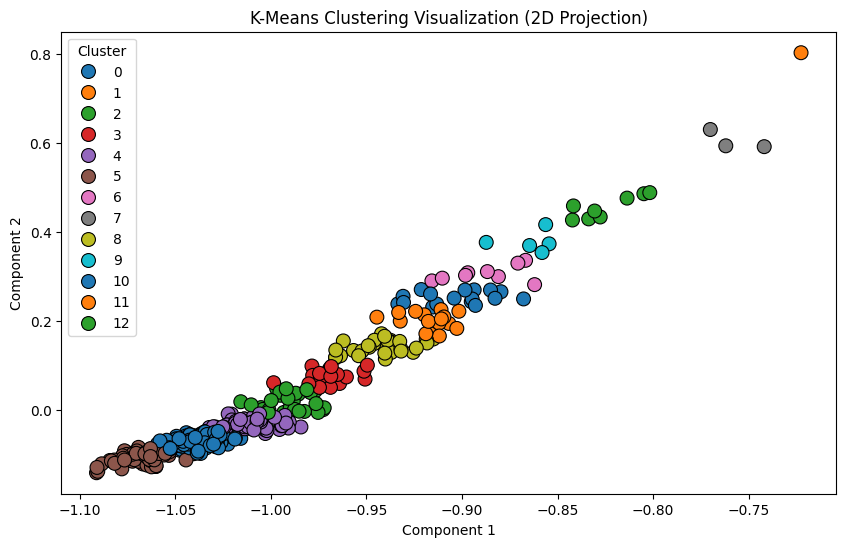

Finished displaying at: 2025-03-09 10:25:32 

Finished executing at: 2025-03-09 10:25:32 



In [195]:
run_k_means(13, documents)